# Generative Dog Images

[Competition link](https://www.kaggle.com/c/generative-dog-images)  

This is first GAN competition in kaggle, below is some reference

### reference: 

[Kernels]  
- [RaLSGAN dogs 000213](https://www.kaggle.com/titericz/ralsgan-dogs-vladislav-bakhteev-kernel)
- [Show Annotations and Breeds](https://www.kaggle.com/paulorzp/show-annotations-and-breeds)
- [RAM DataLoader](https://www.kaggle.com/speedwagon/ram-dataloader)
- [RaLSGAN dogs cropping random](https://www.kaggle.com/sakami/ralsgan-dogs-cropping-random)
  
  
[Discussions]
- [Error in Starter Code](https://www.kaggle.com/c/generative-dog-images/discussion/99613#latest-574385)
- [RaLSGAN Explained](https://www.kaggle.com/c/generative-dog-images/discussion/99485#latest-580430)

In [1]:
from functools import partial
import os
from pathlib import Path
import random
import shutil
import time
import xml.etree.ElementTree as ET

from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from scipy.stats import truncnorm
import torch
from torch import nn, optim
from torch.optim.optimizer import Optimizer
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.datasets.folder import default_loader
from torchvision.utils import save_image
from torchsummary import summary

### Hyper parameter setting  

In [2]:
start_time = time.time()

batch_size = 32
epochs = 300
seed = 1029

TRAIN_DIR = Path('./all-dogs/')
ANNOTATION_DIR = Path('./annotation/Annotation/')

device = torch.device('cuda')

lr = 0.0005
beta1 = 0.5
nz = 256

real_label = 0.95

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

### Model structure

#### Generator
The enter noise is 128* 1 * 1 vector.  
Through several convolution transpose, the output is 3* 64* 64(image).   

#### Discriminator  
RALSGAN final output is one convolution layer without activation function.  
Then it would let the output data project to (-∞,∞).  
Then calculate the distance between target and generative image.  

In [3]:
class Generator(nn.Module):
    
    def __init__(self, nz=128, channels=3):
        super(Generator, self).__init__()
        self.nz = nz
        self.channels = channels
        
        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0):
            block = [
                nn.ConvTranspose2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(n_output),
                nn.ReLU(inplace=True),
            ]
            return block

        self.model = nn.Sequential(
            *convlayer(self.nz, 1024, 4, 1, 0),
            *convlayer(1024, 512, 4, 2, 1),
            *convlayer(512, 256, 4, 2, 1),
            *convlayer(256, 128, 4, 2, 1),
            *convlayer(128, 64, 4, 2, 1),
            nn.ConvTranspose2d(64, self.channels, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(-1, self.nz, 1, 1)
        img = self.model(z)
        return img


class Discriminator(nn.Module):
    
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()
        self.channels = channels

        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0, bn=False):
            block = [nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False)]
            if bn:
                block.append(nn.BatchNorm2d(n_output))
            block.append(nn.LeakyReLU(0.2, inplace=True))
            return block

        self.model = nn.Sequential(
            *convlayer(self.channels, 32, 4, 2, 1),
            *convlayer(32, 64, 4, 2, 1),
            *convlayer(64, 128, 4, 2, 1, bn=True),
            *convlayer(128, 256, 4, 2, 1, bn=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False)
        )

    def forward(self, imgs):
        out = self.model(imgs)
        return out.view(-1, 1)

### Model struture review

This is a useful visulization module for someone who is familiar with Keras.  
[pytorch-summary](https://github.com/sksq96/pytorch-summary)

In [4]:
net_g = Generator(nz).to(device)
net_d = Discriminator().to(device)

summary(net_g,(nz,))
summary(net_d,(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 1024, 4, 4]       4,194,304
       BatchNorm2d-2           [-1, 1024, 4, 4]           2,048
              ReLU-3           [-1, 1024, 4, 4]               0
   ConvTranspose2d-4            [-1, 512, 8, 8]       8,388,608
       BatchNorm2d-5            [-1, 512, 8, 8]           1,024
              ReLU-6            [-1, 512, 8, 8]               0
   ConvTranspose2d-7          [-1, 256, 16, 16]       2,097,152
       BatchNorm2d-8          [-1, 256, 16, 16]             512
              ReLU-9          [-1, 256, 16, 16]               0
  ConvTranspose2d-10          [-1, 128, 32, 32]         524,288
      BatchNorm2d-11          [-1, 128, 32, 32]             256
             ReLU-12          [-1, 128, 32, 32]               0
  ConvTranspose2d-13           [-1, 64, 64, 64]         131,072
      BatchNorm2d-14           [-1, 64,

### Data generator

The Kaggle provides amount of photo with the dog and its bbox.  
In order to get a better result, it needs to focus on dog image.  
Therefore, crop dog image is necessary, and skip the image if the image is rectangular.  

In [5]:
class DogsDataset(Dataset):
    
    def __init__(self, root, annotation_root, transform=None,
                 target_transform=None, loader=default_loader):
        self.root = Path(root)
        self.annotation_root = Path(annotation_root)
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader
        self.imgs = self.cut_out_dogs()

    def _get_annotation_path(self, img_path):
        dog = Path(img_path).stem
        breed = dog.split('_')[0]
        breed_dir = next(self.annotation_root.glob(f'{breed}-*'))
        return breed_dir / dog
    
    @staticmethod
    def _get_dog_box(annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()
        objects = root.findall('object')
        for o in objects:
            bndbox = o.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            yield (xmin, ymin, xmax, ymax)
            
    def crop_dog(self, path):
        imgs = []
        annotation_path = self._get_annotation_path(path)
        for bndbox in self._get_dog_box(annotation_path):
            ratio = (bndbox[3]-bndbox[1])/(bndbox[2]-bndbox[0])
            if ratio > 1.4 or ratio < 0.7:
                continue
            img = self.loader(path)
            img_ = img.crop(bndbox)
            if np.sum(img_) != 0:
                img = img_
            imgs.append(img)
        return imgs
                
    def cut_out_dogs(self):
        imgs = []
        for x in self.root.iterdir():
            img = self.crop_dog(x)
            if len(img) is not 0:
                imgs.append(img)
        return imgs
    
    def __getitem__(self, index):
        samples = random.choice(self.imgs[index])
        if self.transform is not None:
            samples = self.transform(samples)
        return samples
    
    def __len__(self):
        return len(self.imgs)

### Learning rate schedual

In order to get better result.  
Apply the lr schedaul schedual usually get better result.  
Here is two step cos learning schedual

In [6]:
class ParamScheduler(object):
    
    def __init__(self, optimizer, scale_fn, step_size):
        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        
        self.optimizer = optimizer
        self.scale_fn = scale_fn
        self.step_size = step_size
        self.last_batch_iteration = 0
        
    def batch_step(self):
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.scale_fn(self.last_batch_iteration / self.step_size)
        
        self.last_batch_iteration += 1


def combine_scale_functions(scale_fns, phases=None):
    if phases is None:
        phases = [1. / len(scale_fns)] * len(scale_fns)
    phases = [phase / sum(phases) for phase in phases]
    phases = torch.tensor([0] + phases)
    phases = torch.cumsum(phases, 0)
    
    def _inner(x):
        idx = (x >= phases).nonzero().max()
        actual_x = (x - phases[idx]) / (phases[idx + 1] - phases[idx])
        return scale_fns[idx](actual_x)
        
    return _inner


def scale_cos(start, end, x):
    return start + (1 + np.cos(np.pi * (1 - x))) * (end - start) / 2

In [7]:
random_transforms = [transforms.RandomRotation(degrees=10)]
transform = transforms.Compose([transforms.Resize((64,64)),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomApply(random_transforms, p=0.3),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = DogsDataset(TRAIN_DIR , ANNOTATION_DIR, transform=transform)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=0)


scale_fn = combine_scale_functions([partial(scale_cos, 1e-5, 5e-4), partial(scale_cos, 5e-4, 1e-4)], [0.2, 0.8])

optimizer_g = optim.Adam(net_g.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_d = optim.Adam(net_d.parameters(), lr=lr, betas=(beta1, 0.999))

scheduler_g = ParamScheduler(optimizer_g, scale_fn, epochs * len(train_loader))
scheduler_d = ParamScheduler(optimizer_d, scale_fn, epochs * len(train_loader))

In [8]:
len(train_data)

13613

In [10]:
tcheck = time.time()

for epoch in range(epochs):
    for i, real_images in enumerate(train_loader):
        # --------------------------------------
        # Update Discriminator network: maximize log(D(x)) + log(1 - D(G(z)))
        # --------------------------------------
        net_d.zero_grad()
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size, 1), real_label, device=device)
        
        scheduler_d.batch_step()
        output_real = net_d(real_images)
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = net_g(noise)
        output_fake = net_d(fake.detach())
        err_d = (torch.mean((output_real - torch.mean(output_fake) - labels) ** 2) + 
                 torch.mean((output_fake - torch.mean(output_real) + labels) ** 2)) / 2
        err_d.backward(retain_graph=True)
        optimizer_d.step()
        
        # --------------------------------------
        # Update Generator network: maximize log(D(G(z)))
        # --------------------------------------
        net_g.zero_grad()
        scheduler_g.batch_step()
        output_fake = net_d(fake)   
        err_g = (torch.mean((output_real - torch.mean(output_fake) + labels) ** 2) +
                 torch.mean((output_fake - torch.mean(output_real) - labels) ** 2)) / 2
        err_g.backward()
        optimizer_g.step()
        
    print(f'[{epoch + 1}/{epochs}] Loss_d: {err_d.item():.4f} Loss_g: {err_g.item():.4f} time: {time.time()-tcheck:.2f}')
    tcheck=time.time()

[1/300] Loss_d: 2.4118 Loss_g: 0.9537 time: 80.79
[2/300] Loss_d: 0.7421 Loss_g: 2.0543 time: 80.70
[3/300] Loss_d: 0.2178 Loss_g: 3.4362 time: 80.28
[4/300] Loss_d: 0.2883 Loss_g: 3.7518 time: 80.60
[5/300] Loss_d: 0.0918 Loss_g: 3.1253 time: 80.84
[6/300] Loss_d: 0.2283 Loss_g: 3.1125 time: 80.55
[7/300] Loss_d: 2.9377 Loss_g: 0.4841 time: 80.64
[8/300] Loss_d: 0.9116 Loss_g: 1.0806 time: 80.50
[9/300] Loss_d: 0.8455 Loss_g: 1.1363 time: 80.32
[10/300] Loss_d: 1.0298 Loss_g: 0.9558 time: 80.32
[11/300] Loss_d: 1.1103 Loss_g: 1.1568 time: 80.70
[12/300] Loss_d: 0.7978 Loss_g: 1.3372 time: 80.44
[13/300] Loss_d: 1.2484 Loss_g: 1.0926 time: 80.43
[14/300] Loss_d: 0.6031 Loss_g: 1.7235 time: 80.80
[15/300] Loss_d: 0.6215 Loss_g: 2.3587 time: 80.37
[16/300] Loss_d: 0.3543 Loss_g: 3.1608 time: 81.12
[17/300] Loss_d: 1.4489 Loss_g: 1.7318 time: 81.12
[18/300] Loss_d: 1.1507 Loss_g: 1.8392 time: 80.86
[19/300] Loss_d: 0.8409 Loss_g: 2.0187 time: 80.79
[20/300] Loss_d: 0.3219 Loss_g: 3.3527 t

In [11]:
def truncated_normal(size, threshold=1):
    values = truncnorm.rvs(-threshold, threshold, size=size)
    return values

In [46]:
z = truncated_normal((1, nz, 1, 1), threshold=1)
z[0,1,0,0]

0.26024138636922706

In [12]:
im_batch_size = 50
n_images = 10000


for i_batch in range(0, n_images, im_batch_size):
    z = truncated_normal((im_batch_size, nz, 1, 1), threshold=1)
    gen_z = torch.from_numpy(z).float().to(device)
    gen_images = (net_g(gen_z) + 1) / 2
    images = gen_images.to('cpu').clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    #for i_image in range(gen_images.size(0)):
    #    save_image(gen_images[i_image, :, :, :], OUT_DIR / f'image_{i_batch + i_image:05d}.png')

In [13]:
images.shape

(50, 64, 64, 3)

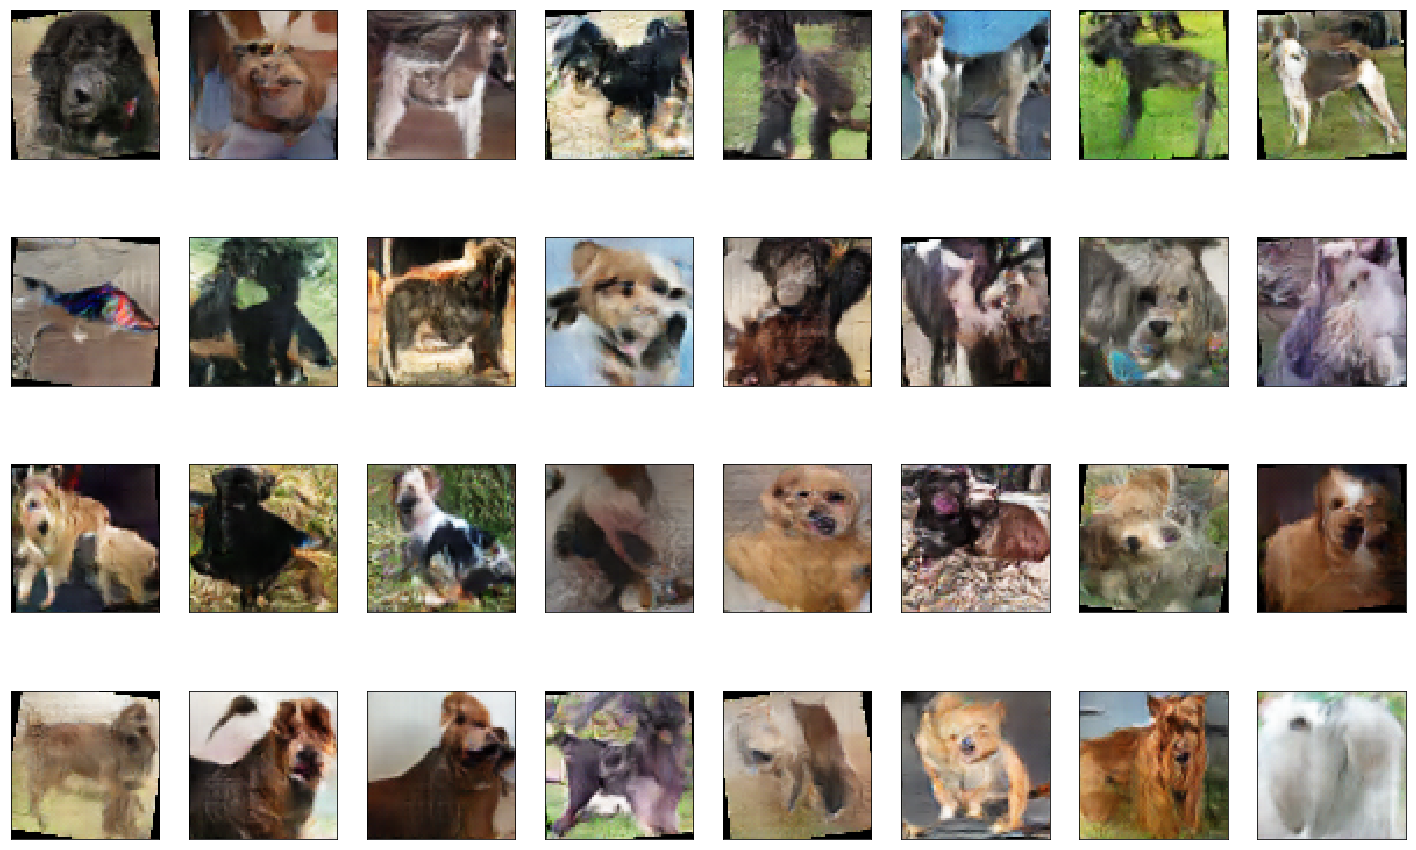

In [14]:
fig = plt.figure(figsize=(25, 16))
for i, j in enumerate(images[:32]):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    plt.imshow(j)

In [15]:
elapsed_time = time.time() - start_time
print(f'All process done in {int(elapsed_time // 3600)} hours {int(elapsed_time % 3600 // 60)} min.')

All process done in 6 hours 9 min.


In [16]:
torch.save(net_g, 'dog_gen_ralsgan2.pkl')
torch.save(net_d, 'dog_dis_ralsgan2.pkl')

C:\Users\a2720\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\a2720\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
OUT_DIR = Path('./output_images/')
OUT_DIR.mkdir(exist_ok=True)
shutil.make_archive('images', 'zip', OUT_DIR)

Walk in Latent Space


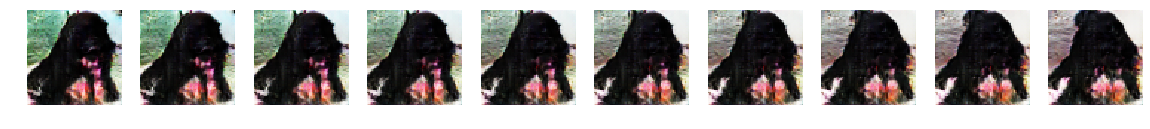

Walk in Latent Space


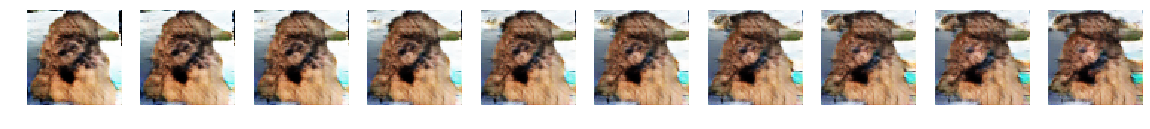

Walk in Latent Space


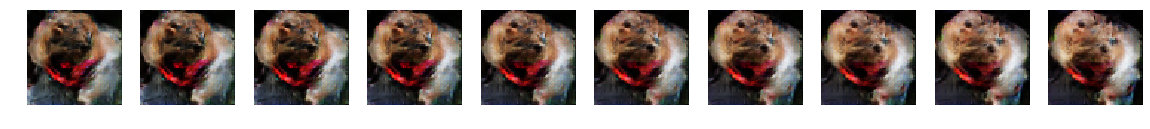

Walk in Latent Space


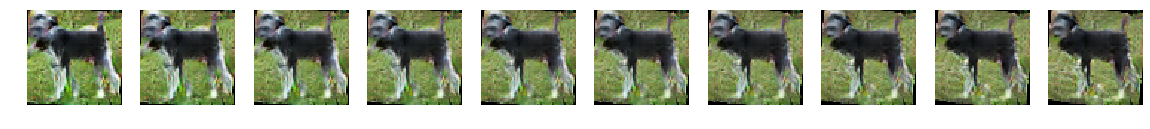

Walk in Latent Space


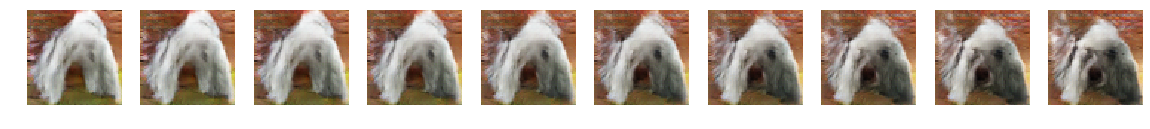

Walk in Latent Space


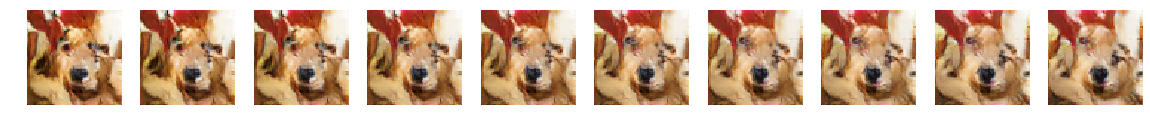

Walk in Latent Space


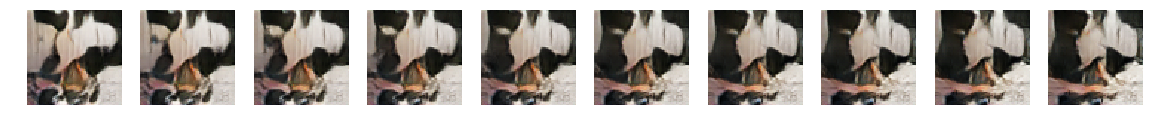

Walk in Latent Space


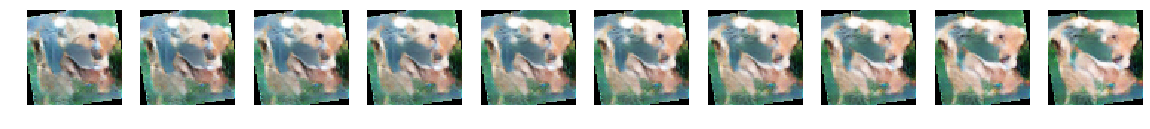

Walk in Latent Space


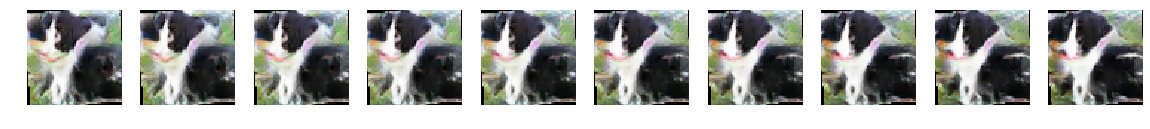

Walk in Latent Space


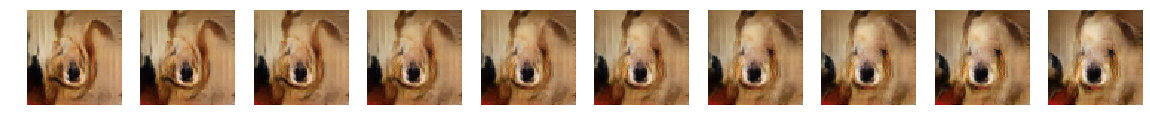

In [77]:
xx = truncated_normal((10, nz, 1, 1), threshold=1)
for k in range(10):
    print('Walk in Latent Space') 
    a = np.random.randint(int(nz/2)-10)
    b = np.random.randint(int(nz/2)-10)
    plt.figure(figsize=(20,2))
    for j in range(10):
        theta = j/9
        xx[k,a:a+10,0,0] = theta; xx[k,b+int(nz/2):b+int(nz/2)+10,0,0] = 1-theta
        gen_z = torch.from_numpy(xx).float().to(device)
        plt.subplot(1,10,j+1)
        img = (net_g(gen_z) + 1) / 2
        images = img.to('cpu').clone().detach()
        images = images.numpy().transpose(0, 2, 3, 1)
        plt.axis('off')
        plt.imshow(images[k])
    plt.show()